In [125]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# beyasian modeling
import bambi as bmb

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

In [126]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = '/home/jovyan/work/scripts'
scripts_dir = '/home/jovyan/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from InferenceDataFromHDDM import InferenceDataFromHDDM
from plot_ppc_by_cond import plot_ppc_by_cond

In [127]:
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.4
print('The current PyMC version is', pymc.__version__) # 2.3.8
print('The current Numpy version is', np.__version__) 
print('The current Pandas version is', pd.__version__)
print('The current seaborn version is', sns.__version__)

The current HDDM version is 0.8.0
The current Kabuki version is 0.6.4
The current PyMC version is 2.3.8
The current Numpy version is 1.20.3
The current Pandas version is 1.3.5
The current seaborn version is 0.11.2


In [128]:
# set the figure theme
sns.set_theme(style="whitegrid")

Maybe the generation way of simulated data should make a difference.

In the past scripts, we use the way:
 
$$parameter_{j}=\beta_{0,j} + \beta_{1,j}*C(condition)$$

$$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $$

$$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$$

So, we can test which data structure is useful, we generate the data from the simplest way(without condition)

# the simplest model

Instead of generate the subject params via sample param form a distribution with the group params, we sample the random error from the group error distribution. And then add the subject error to the group params.

## generate data

In [22]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 200

# set the group parameter
# intercept and slope of v
v_int = 1
v_sig = 0.05
# intercept and slope of z
z_int = 0.5
z_sig = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of t
t_int = 0.2
t_sig = 0.05

In [111]:
# set the subject parameter
# v
v_err_subj = np.random.normal(0,v_sig,n_subjects)
# z
z_err_subj = np.random.normal(0,z_sig,n_subjects)
# a
a_err_subj = np.random.normal(0,a_sig,n_subjects)
# t
t_err_subj = np.random.normal(0,t_sig,n_subjects)

# dataframe
df = pd.DataFrame()
param = pd.DataFrame()
for i in range(n_subjects):
    
    # v of subject 
    v  = v_int + v_err_subj[i]
    # z of subject
    z  = z_int + z_err_subj[i]
    # the default parameter a
    a  = a_int + a_err_subj[i]
    # the default parameter t
    t  = t_int + t_err_subj[i]
    
    # set up parameters of DDM for four levels 
    level = {'v':v, 'a':a, 't':t, 'z':z, 'sv':0, 'sz':0, 'st':0}
    
    # generate simulated data
    np.random.seed(123)
    data, params = hddm.generate.gen_rand_data({'level':level},
                                                 size = trials_per_level
                                                  )
    # data
    data['subj_idx'] = i
    df = df.append(data)
    
    # params
    # create dataframe
    params = pd.DataFrame([params])
    # add subject
    params['subj_idx'] = i
    # combine params
    param = param.append(params)
# reset the index
param = param.reset_index(drop=True)

### the ground value

In [112]:
# select the specific coloumn
param = param[['v','a','t','z','subj_idx']]
# store the wide data to linear regression
param_pm = param
# wide to long
param = param.melt(id_vars='subj_idx', 
                   var_name='param', 
                   value_name='value' )
param

subj_idx param     value
0           0     v  0.962959
1           1     v  1.003645
2           2     v  1.020154
3           3     v  1.073596
4           4     v  1.015369
..        ...   ...       ...
115        25     z  0.472506
116        26     z  0.475253
117        27     z  0.502481
118        28     z  0.467991
119        29     z  0.515077

[120 rows x 3 columns]

Text(0.5, 0, 't')

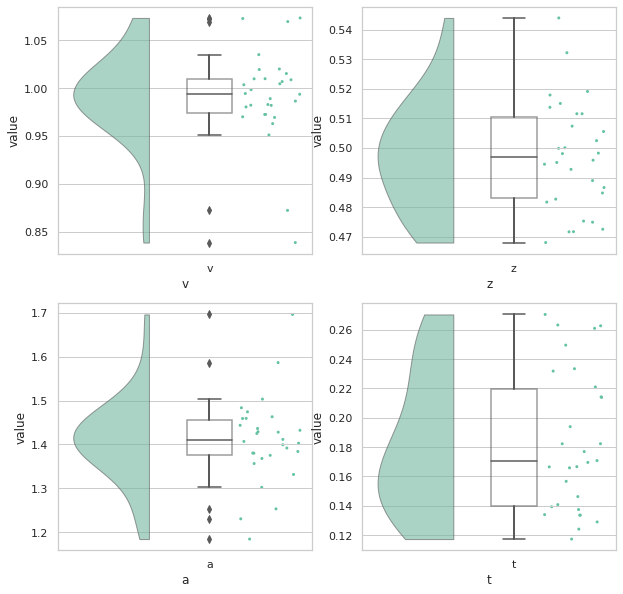

In [114]:
# create figure
f, ax = plt.subplots(2,2,figsize=(10, 10))
# the right figure
# v
ax[0,0]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='v'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,0])
ax[0,0].set_xlabel('v')
# z
ax[0,1]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='z'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[0,1])
ax[0,1].set_xlabel('z')
# a
ax[1,0]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='a'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,0])
ax[1,0].set_xlabel('a')
# t
ax[1,1]=pt.RainCloud(x = 'param', 
                  y = 'value', 
                  data = param[param['param']=='t'], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax=ax[1,1])
ax[1,1].set_xlabel('t')


we get the mean and std of all params

In [123]:
print('the mean of parameter v is {:.3f} and the std is {:.3f} '.format(param_pm.v.mean(), param_pm.v.std()))
print('the mean of parameter z is {:.3f} and the std is {:.3f} '.format(param_pm.z.mean(), param_pm.z.std()))
print('the mean of parameter a is {:.3f} and the std is {:.3f} '.format(param_pm.a.mean(), param_pm.a.std()))
print('the mean of parameter t is {:.3f} and the std is {:.3f} '.format(param_pm.t.mean(), param_pm.t.std()))

the mean of parameter v is 0.992 and the std is 0.048 
the mean of parameter z is 0.497 and the std is 0.019 
the mean of parameter a is 1.409 and the std is 0.097 
the mean of parameter t is 0.183 and the std is 0.048 


### the rt distribution

<AxesSubplot:xlabel='response', ylabel='rt'>

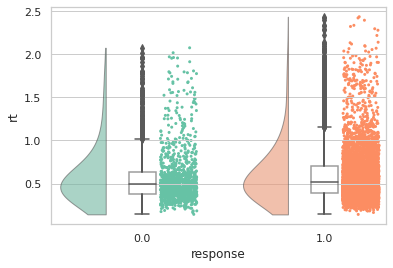

In [30]:
# the rt distribution
pt.RainCloud(x = 'response', 
                  y = 'rt', 
                  data = df, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2)

### hlm

In [31]:
# contrust model
m1 = bmb.Model("v ~ 1 + (1|subj_idx)", data=param_pm)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 10 seconds.
There were 668 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6725073520307322, but should be close to 0.8. Try to increase the number of tuning steps.
There were 411 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1531 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.492973506229809, but should be close to 0.8. Try to increase the number of tuning steps.
There were 638 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6242643674407169, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during s

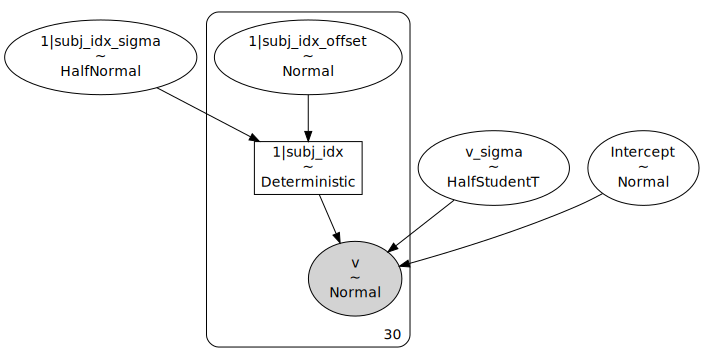

In [32]:
m1.build()
m1.graph()

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>], dtype=object)

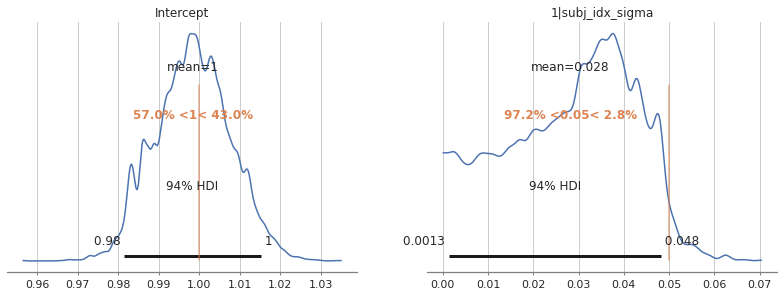

In [33]:
az.plot_posterior(res1, 
                  var_names=['Intercept','1|subj_idx_sigma'], 
                  ref_val=[v_int,v_sig]
                 )

## fit data

in the model, we set the regression of all four parameters, and each parameter only has the varing intercept.

In [22]:
def ms1(id, df=None, samples=None, burn=None, thin=1,save_name='ms1'):
    '''
    id: the id of cpu thread
    df: the input data
    samples: number of samples for MCMC
    burn: number of burn-in of MCMC
    thin: number of thin
    save_name: prefix of file name when saving the model object
    '''
    print('running chain {:d} for model {}'.format(id, save_name))
    # the database file
    dbname = save_name + '_chain_%i.db'%id
    # the model object store here
    mname = save_name + '_chain_%i'%id

    v_reg = {'model':'v~1','link_func':lambda x:x}
    z_reg = {'model':'z~1','link_func':lambda x:x}
    t_reg = {'model':'t~1','link_func':lambda x:x}
    a_reg = {'model':'a~1','link_func':lambda x:x}
    reg_descr = [v_reg, 
                 z_reg,
                 t_reg,
                 a_reg,]
    m = hddm.HDDMRegressor(df, 
                           reg_descr, 
                           include=['z'],
                           group_only_regressors=False,
                           keep_regressor_trace=True
                          )
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save
    m.save(mname)

    return m

In [20]:
samples = 4000    # number of MCMC sample
burn = 1000       # number of burn in
nppc = 500        # number of posterior predictive
thin = 2           # thining
chains = 4         # number of chains
savefile= True     # save file or not, only "True" is available for now.
savetag = None     # tag added to saved files.
model_func = [ms1]

In [23]:
ms1res = Parallel(n_jobs = 1)(delayed(ms1)(id = i, df = df, samples=10000,burn = 1000,thin=2, save_name = 'ms1' ) for i in range(1))

running chain 0 for model ms1
Adding these covariates:
['v_Intercept']
Adding these covariates:
['z_Intercept']
Adding these covariates:
['t_Intercept']
Adding these covariates:
['a_Intercept']
 [-----------------100%-----------------] 10001 of 10000 complete in 39506.6 secWARNING: Will not save custom link functions.


In [6]:
ms1res = []
ms1res.append(hddm.load('ms1_chain_0'))

In [13]:
%%time
InfData_ms1 = InferenceDataFromHDDM(ms1res, nppc = 100, save_name="ms1")

start converting ms1


  0%|          | 0/2 [00:00<?, ?it/s]

started to generate posterior predicitves
started to generate posterior predicitves


NotImplementedError: Supply a grouping so that at most 1 observed node codes for each group.

In [6]:
az.plot_trace(InfData_ms1)

NameError: name 'InfData_ms1' is not defined

### the sampling trace

if we use ``HDDM`` rather than ``HDDMRegressor``, the result is similar to below.

Plotting v_Intercept
Plotting v_Intercept_std
Plotting z_Intercept
Plotting z_Intercept_std
Plotting t_Intercept
Plotting t_Intercept_std
Plotting a_Intercept
Plotting a_Intercept_std


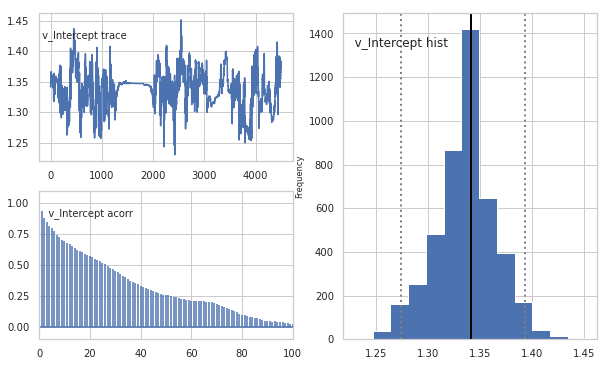

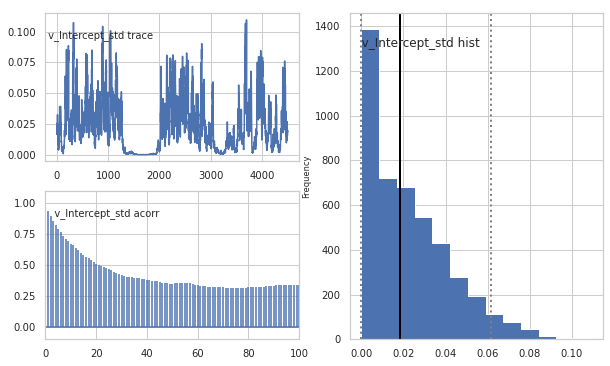

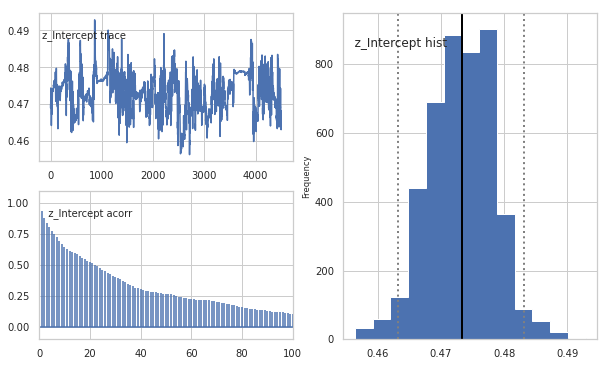

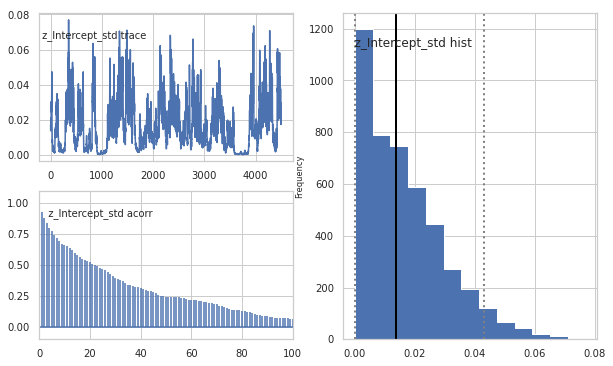

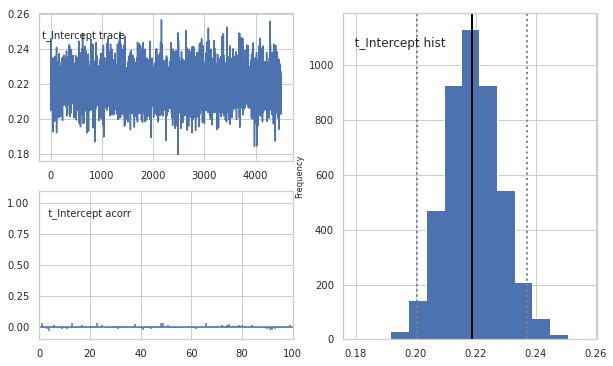

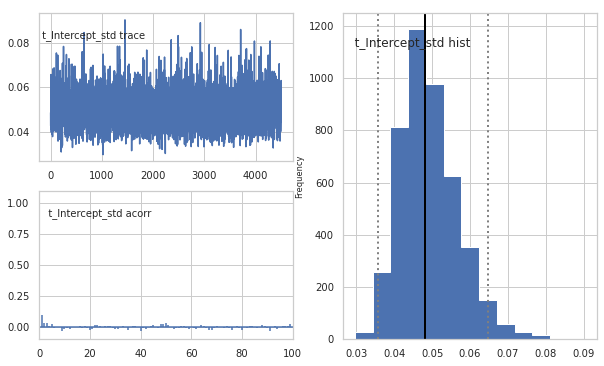

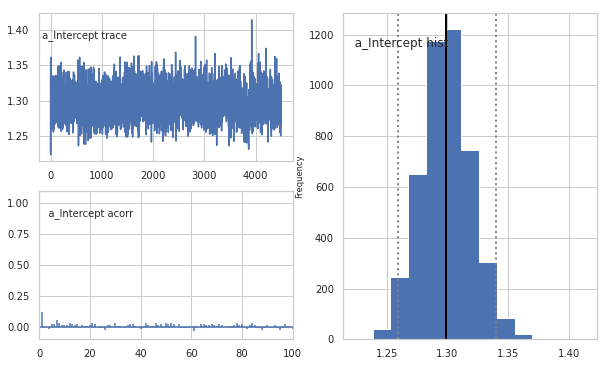

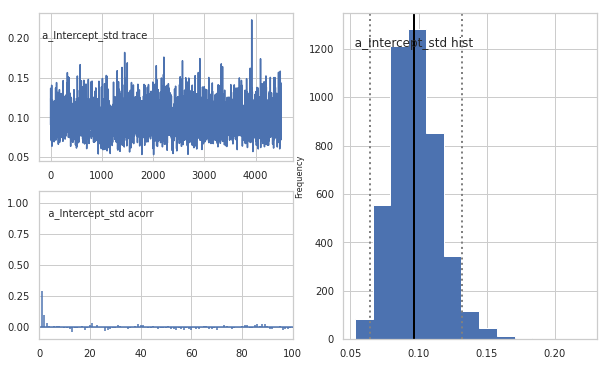

In [24]:
ms1res[0].plot_posteriors()

In [31]:
ms1res[0].get_traces().to_csv('m1res.csv')

In [129]:
m1res_trace = pd.read_csv('m1res.csv')

### the group effect

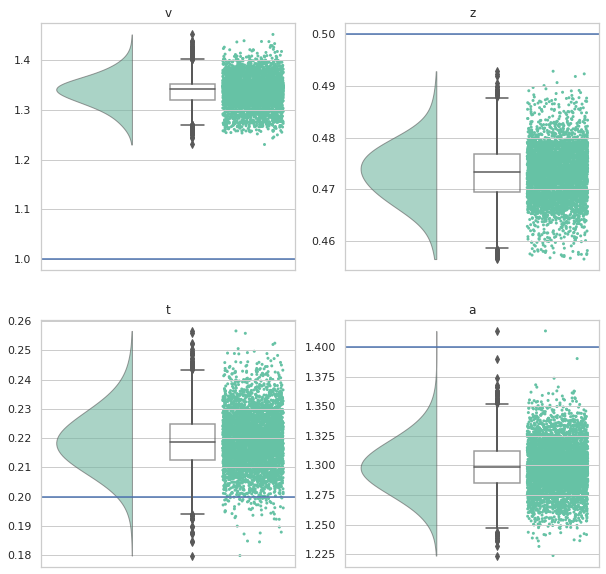

In [139]:
pms = ['v','z','t','a']
# create figure
f,ax = plt.subplots(2,2,figsize=(10,10))
for i,pm in enumerate(pms):
    if pm != 'z':
        varname = os.path.join(str(pm +'_Intercept'))
        data = m1res_trace[varname]
    else:
        varname = os.path.join(str(pm +'_Intercept_trans'))
        data = 1/(1+np.exp(-m1res_trace[varname]))
    # ground parameter of group effect
    gpm = eval(os.path.join(pm+'_int'))
    # raincloud
    ax_i = ax[i//2,i%2]
    ax_i = pt.RainCloud(data = data, 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(gpm)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(pm)

### the subject effcet

#### v

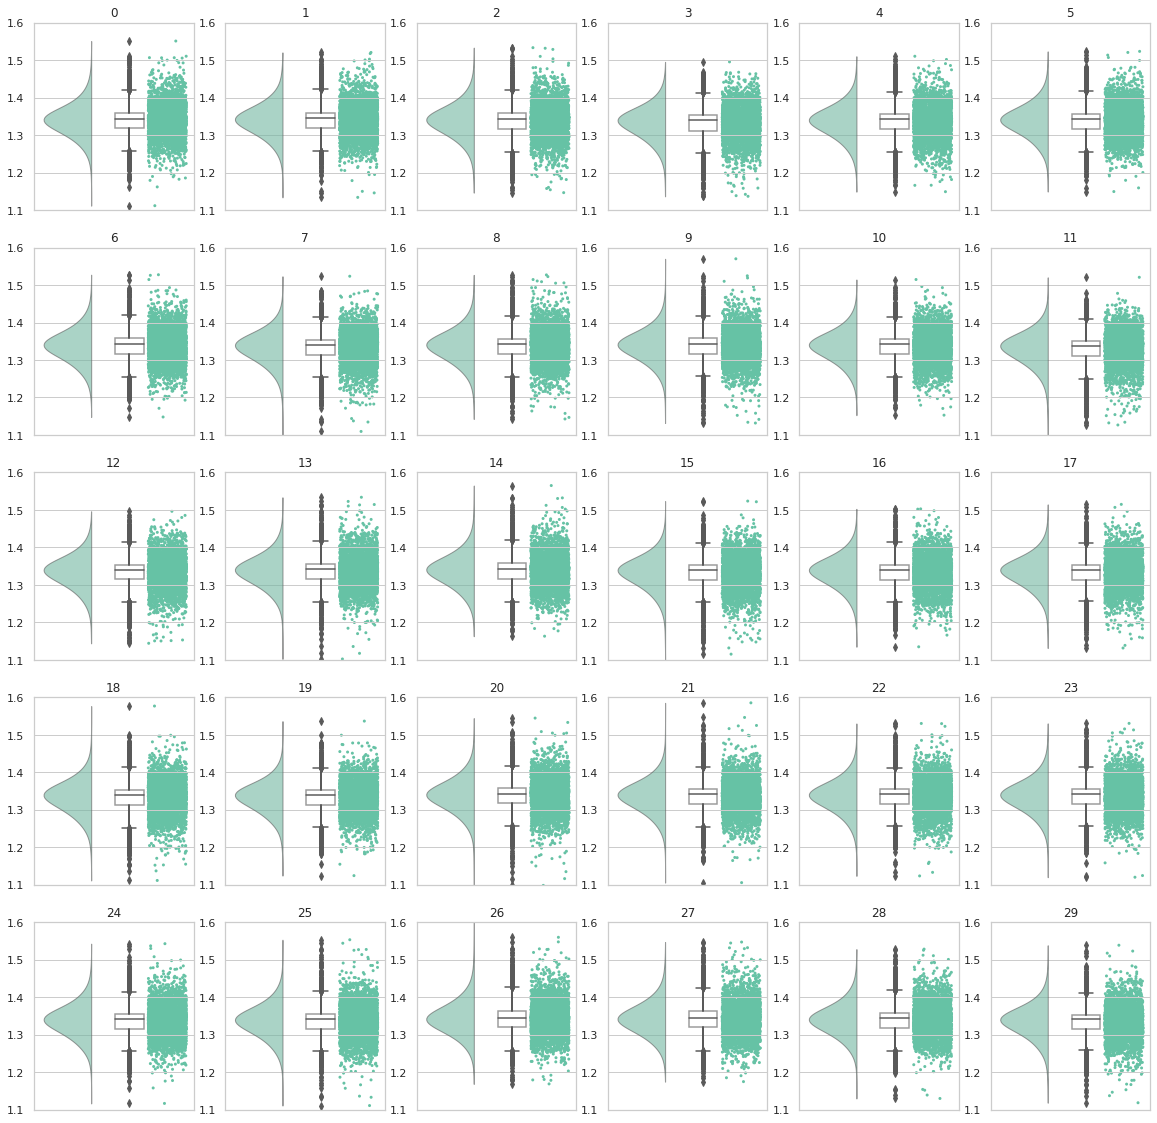

In [170]:
param = 'v'
# create figure
f,ax = plt.subplots(5,6,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'v'].values[0]
    # raincloud
    ax_i = ax[i//6,i%6]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.set_ylim(1.1,1.6)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### z

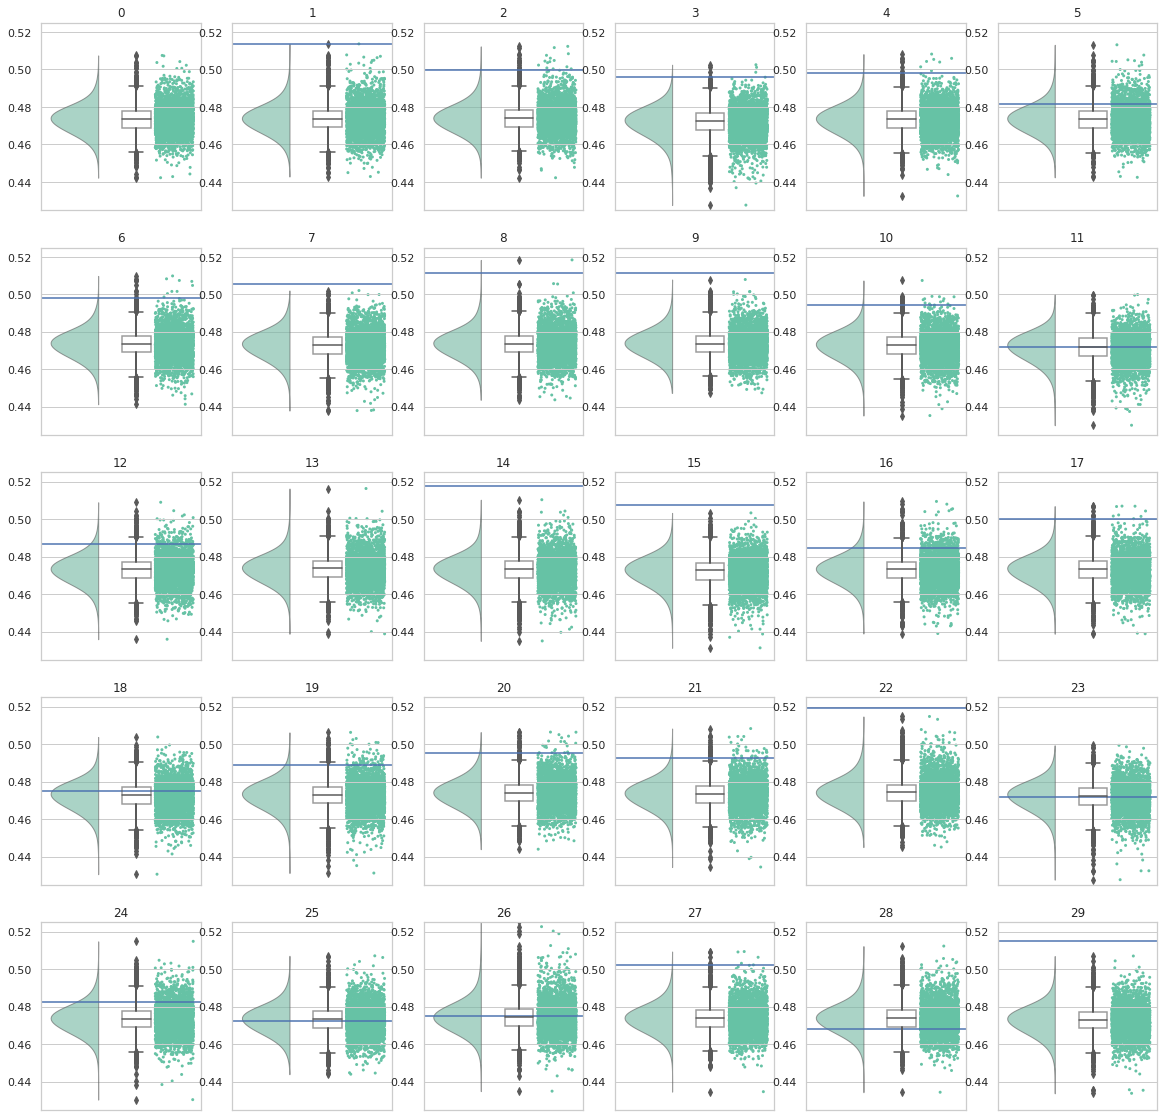

In [171]:
param = 'z'
# create figure
f,ax = plt.subplots(5,6,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj_trans.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'z'].values[0]
    # raincloud
    ax_i = ax[i//6,i%6]
    ax_i = pt.RainCloud(data = 1/(1+np.exp(-m1res_trace[varname])), 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.set_ylim(0.425,0.525)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### t

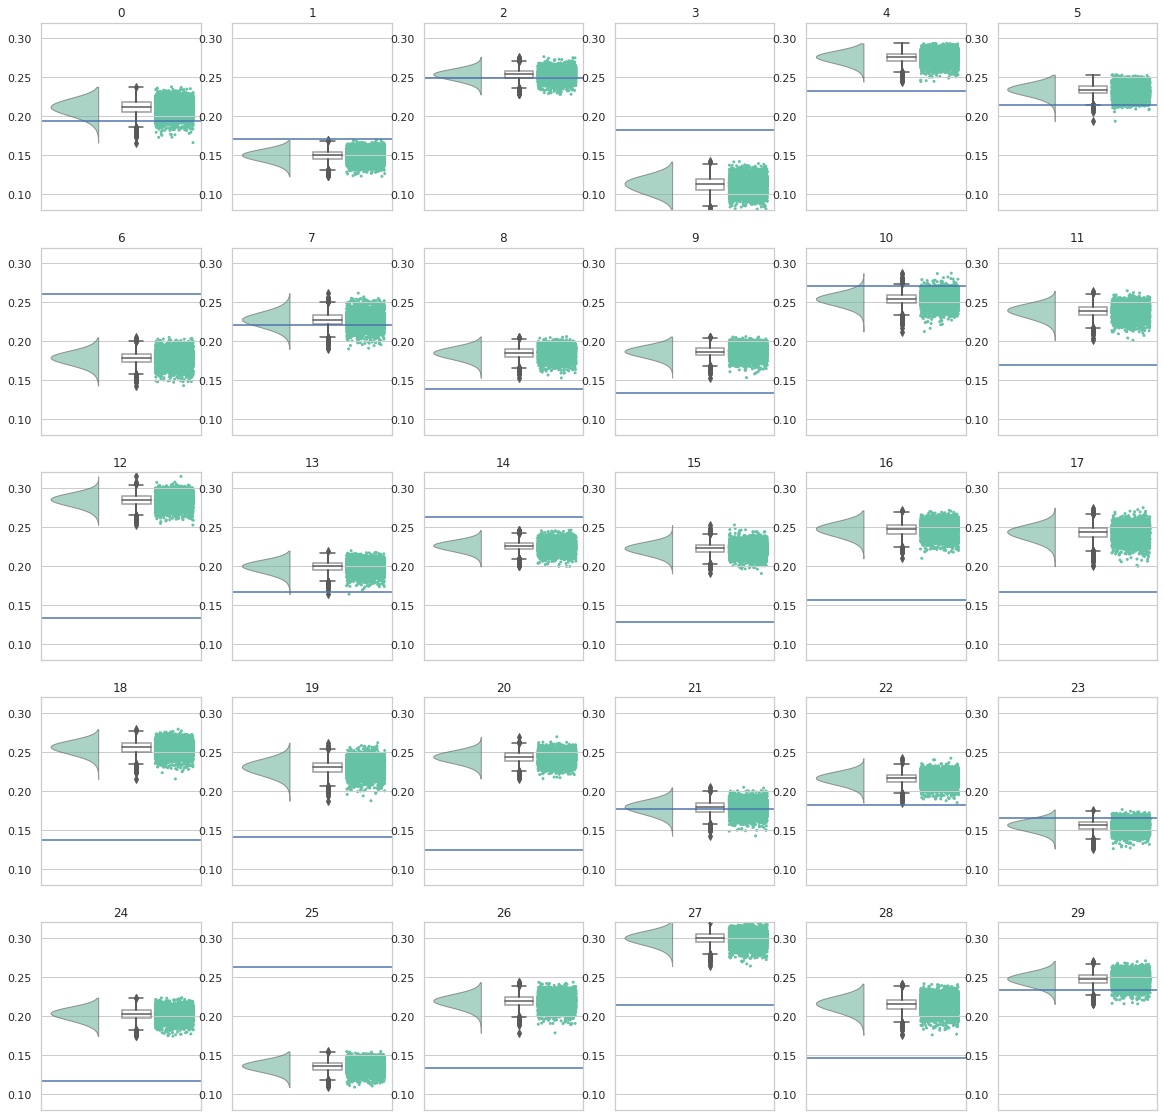

In [172]:
param = 't'
# create figure
f,ax = plt.subplots(5,6,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'t'].values[0]
    # raincloud
    ax_i = ax[i//6,i%6]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.set_ylim(0.08,0.32)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)

#### a

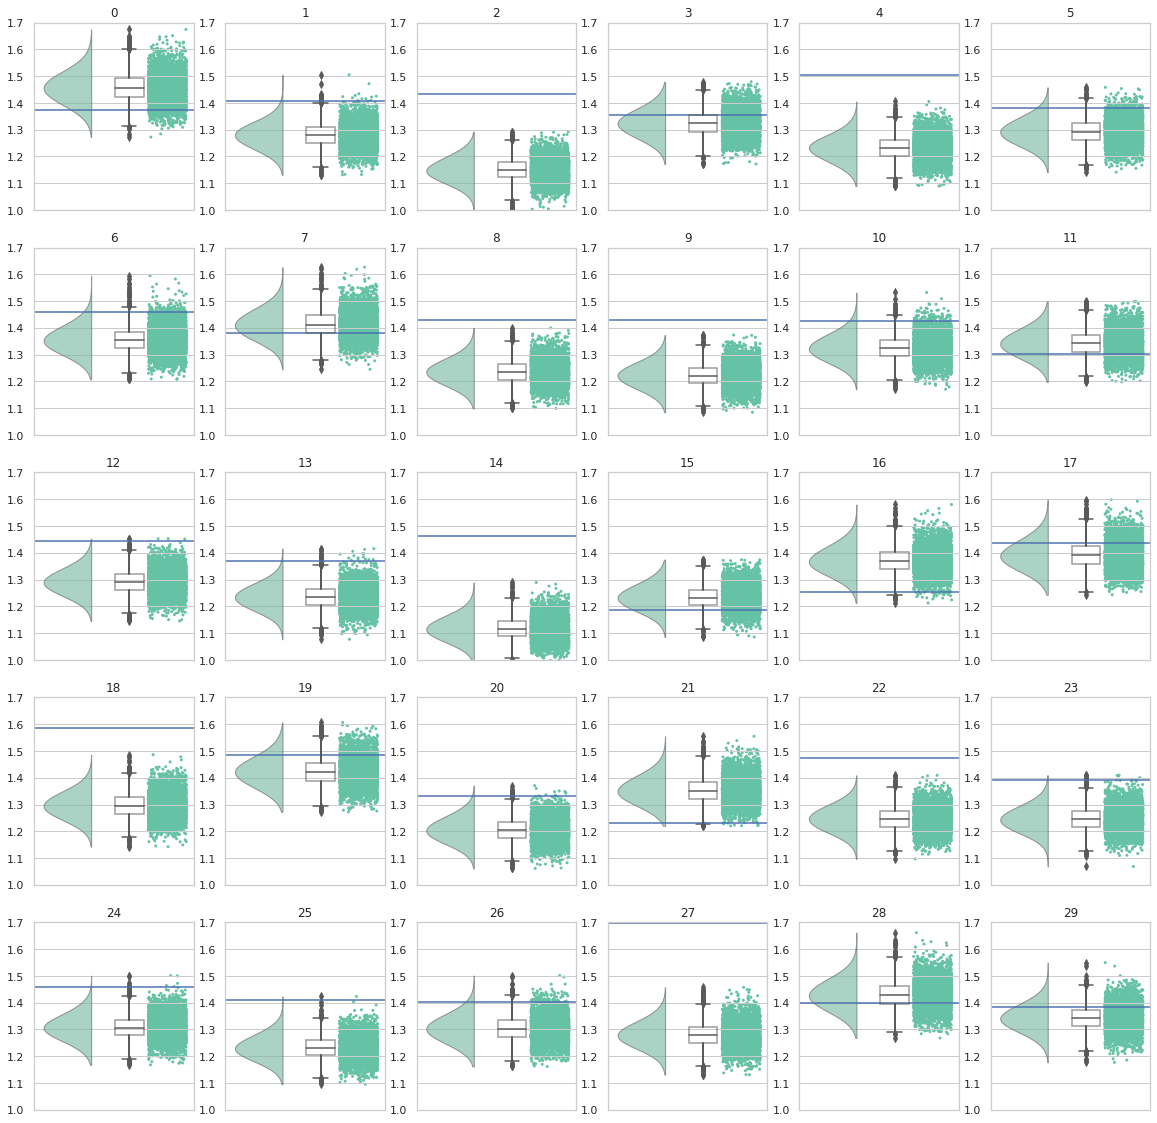

In [175]:
param = 'a'
# create figure
f,ax = plt.subplots(5,6,figsize=(20,20))
for i in range(n_subjects):
    varname = os.path.join(str(param +'_Intercept_subj.'+ str(i)))
    # ground parameter of subject effect
    spm =  param_pm.loc[param_pm['subj_idx']==i,'a'].values[0]
    # raincloud
    ax_i = ax[i//6,i%6]
    ax_i = pt.RainCloud(data = m1res_trace[varname], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True,  
                  move = 0.2,
                  ax = ax_i)
    ax_i.axhline(spm)
    ax_i.set_ylim(1,1.7)
    ax_i.xaxis.set_visible(False)
    ax_i.set_title(i)